## Webscraping to Investigate [John Bartholomew](https://www.youtube.com/channel/UC6hOVYvNn79Sl1Fc1vx2mYA)'s Impact on [lichess](http://en.lichess.org/) Blitz Games

This brief blog post is documenting how I investigated a thought I had earlier this morning:
> "John Bartholomew's [Youtube channel](https://www.youtube.com/channel/UC6hOVYvNn79Sl1Fc1vx2mYA) has been gaining lots of popularity in the past few months. John is famously a [Scandinavian Defense](https://en.wikipedia.org/wiki/Scandinavian_Defense) player, and most of his videos show him playing on [lichess](http://en.lichess.org/). I wonder if the popularity of this opening on lichess correlates with John's popularity on Youtube?"

Not only is John a strong chess player (International Master en route to Grand Master) and a Scandinavian Defense player, he promotes the playing of the opening on his channel. He started a [#teamscandi](https://twitter.com/search?q=%23teamscandi&src=typd) hashtag on twitter, and is purportedly developing a series on the opening on [chessable](chessable.com).

I'll note that nothing I show in this blog post will make any definitive statement that John is the sole reason for opening popularity changes (correlation does not imply causation!), but I produce a plot that demonstrates that as John's popularity increases, so does the popularity of this opening.

This code behind this is basically some quick-and-dirty web scraping to find John's Youtube statistics, and then some more quick-and-dirty web scraping to find the opening statistics on lichess.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import urllib2
from BeautifulSoup import BeautifulSoup

#### Quantifying John's Popularity

I looked briefly through some Youtube pages to try to find a cleaner resource for the number of subscribers to John's channel has as a function of time, but couldn't find it... Instead, I found this resource "[socialblade](http://socialblade.com/)" which tells me what I want. I navigated through socialblade to get stats for John's channel, read it into a BeautifulSoup object, and parsed it (in a surely suboptimal way... advice appreciated for how I might do it more cleanly!) to extract what I'm interested in.

In [2]:
# Read in the html for the John's youtube stats
jb_yt_stats_url = 'http://socialblade.com/youtube/channel/UC6hOVYvNn79Sl1Fc1vx2mYA/monthly'
# Defining the 'User-Agent' header is necessary otherwise socialblade blocks my url request.
req = urllib2.Request(jb_yt_stats_url, headers={'User-Agent' : "Magic Browser"}) 
con = urllib2.urlopen( req )
soup = BeautifulSoup( con )

Looking at the html result, I see that the data for the chart I'm attemping to copy is inside of a block with some specific strings... so, I grab that block, format it a little bit, and end up with a list of (# of subscribers) data points, and a list of datetime.datetime objects (which pyplot kindly handles for me).

In [3]:
plotstart = "document.getElementById('TotalSubscribers')"
plotend   = "title: 'Total Subscribers Gained for"
souptext  = soup.getText()
plotstartidx = souptext.index(plotstart)
plotendidx   = souptext.index(plotend)
plottext     = souptext[plotstartidx:plotendidx]

plotdata_raw = [ x[:-2] for x in plottext.strip('\n').split('" + "') ][1:]
plotdata_raw[-1] = plotdata_raw[-1][:-9]

mydates = [ x.split(',')[0] for x in plotdata_raw ]
mysubs  = [ x.split(',')[1] for x in plotdata_raw ]
datetimes = [ dt.datetime.strptime(x,'%Y-%m-%d') for x in mydates ]

Let's draw the subscribers vs. time plot, for visualization sake. This plot is also produced on the socialblade site, so I can cross validate it visually.

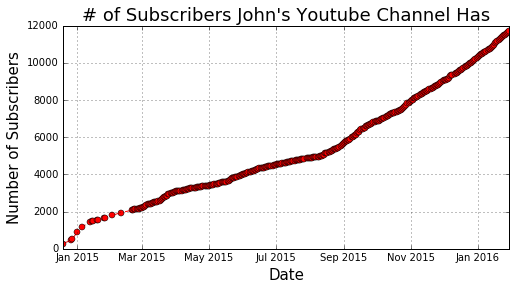

In [4]:
plt.figure(figsize=(8,4))
plt.plot(datetimes,mysubs,'ro--')
plt.title( '# of Subscribers John\'s Youtube Channel Has',fontsize=18)
plt.ylabel('Number of Subscribers',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.grid(True)

Interestingly it looks like the socialblade stats tracker increases its tracking frequency once the youtuber passes 2000 subscribers (the sparsity of dots seems to increase around this value).

OK cool! Now we have a way to see John's rough popularity as a function of time. Next let's get our hands on some lichess data and see what fraction of openings played are 1.e4 d5 (the Scandinavian) as a function of time and see if it correlates!

#### Quantifying Opening Popularity on lichess

After playing around with the lichess api (thanks [Thibault!](https://github.com/ornicar) for your [open source chess website](https://github.com/ornicar/lila)), it seems the api can't give me exactly the information I want. I e-mailed Thibault and he (quickly) responded saying that it was just too much information to serve (several GBs of pgns). I don't blame him, but it means I'll have to get what I'm after in a somewhat more hacky way. You know what that means... more soup!

I notice that in the "[advanced search](http://en.lichess.org/games/search)" section of the site, you can do some basic queries and get a list of games. Unfortunately right now you can't just bulk-download the PGNs of those games (which was my original plan), but I can surely scrape the html result and extract the number of games.

My plan: do a query to see how many games were played in the past month, then do a query and see how many of those were in the Scandinavian opening, and repeat this for various 1-month intervals, and plot that fraction as a function of time. I also track the opening popularity of a generic "King Pawn" opening, which I'm using as something of a control group. This opening is a collection of openings that start with 1.e4 (as the Scandinavian does), but proceed off into less common, ill-defined lines. As a group it has roughly the same popularity as the Scandinavian, and I have no reason to believe the popularity of this opening would change over the past year.

Here's a sample URL that is me querying: Blitz time control, Scandinavian opening, date played is between 6 months ago and 3 months ago:
http://en.lichess.org/games/search?perf=2&opening=B01&dateMin=6m&dateMax=3m&sort.field=d&sort.order=desc

Right now the only time options are 1 year, 6 months, 5 months, 4... 1 month (and shorter), so I won't be able to do more finely binned queries between 1 year and 6 months ago. For the sake of this post, I'll just look at dates reaching back 6 months from today.

As a side note, I spoke with Thibault, and in the next couple of days he will allow monthly queries reaching back farther than 6 months. I'll hopefully update this post once that change goes live on lichess.

In [5]:
# A utility function that takes in a lichess advanced-search URL, 
# and finds the "Number of games played" string 
# (which happens to be easier to find than the Youtube stats above)
def getNGames(myurl):
    req = urllib2.Request(myurl, headers={'User-Agent' : "Magic Browser"}) 
    con = urllib2.urlopen( req )
    soup = BeautifulSoup( con )
    return int(soup.strong.string[:-12].replace(',',''))

In [6]:
dateranges = [('6m','5m'),('5m','4m'),('4m','3m'),('3m','2m'),('2m','1m'),('1m','0d')]
nscandi, ntotal, nkingpwn = [], [], []
for mymin, mymax in dateranges:
    myurl = 'http://en.lichess.org/games/search?perf=2&'
    myurl += 'opening=B01&dateMin=%s&dateMax=%s&sort.field=d&sort.order=desc' % \
            (mymin, mymax)
    nscandi.append(getNGames(myurl))

    myurl = 'http://en.lichess.org/games/search?perf=2&'
    myurl += 'dateMin=%s&dateMax=%s&sort.field=d&sort.order=desc' % \
            (mymin, mymax)
    ntotal.append(getNGames(myurl))
   
    myurl = 'http://en.lichess.org/games/search?perf=2&'
    myurl += 'opening=B00&dateMin=%s&dateMax=%s&sort.field=d&sort.order=desc' % \
            (mymin, mymax)
    nkingpwn.append(getNGames(myurl))
   
    print 'Date ranges: %s to %s:'%(mymin,mymax) 
    print 'Number of (total, scandi, kingpawn) games = (%d, %d, %d)' %\
            (ntotal[-1], nscandi[-1], nkingpwn[-1])

Date ranges: 6m to 5m:
Number of (total, scandi, kingpawn) games = (1751532, 83254, 80658)
Date ranges: 5m to 4m:
Number of (total, scandi, kingpawn) games = (1452544, 69029, 66498)
Date ranges: 4m to 3m:
Number of (total, scandi, kingpawn) games = (2162156, 104978, 99934)
Date ranges: 3m to 2m:
Number of (total, scandi, kingpawn) games = (2413766, 120593, 111220)
Date ranges: 2m to 1m:
Number of (total, scandi, kingpawn) games = (2717695, 138794, 127223)
Date ranges: 1m to 0d:
Number of (total, scandi, kingpawn) games = (3146039, 162375, 145798)


Wow, turns out a lot of Blitz games are played on lichess every month. Also, just looking at the total number of games played in each one-month block, it's clear that lichess itself is gaining popularity (nearly twice as many games played in the last month, as opposed to between five and 6 months ago... go lichess!) Let's compute the fractions I'm after and make the money plot.

In [7]:
scandifrac = [ float(nscandi[x])/ntotal[x] for x in xrange(len(nscandi)) ]
kingpwnfrac = [ float(nkingpwn[x])/ntotal[x] for x in xrange(len(nkingpwn)) ]
months_ago = [ 5.5, 4.5, 3.5, 2.5, 1.5, .5 ]
bincenters = [ dt.datetime.now()-dt.timedelta(days=((365./12)*x)) for x in months_ago ]

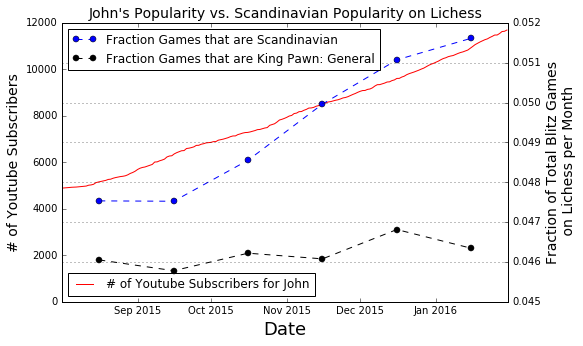

In [8]:
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(datetimes,mysubs,'r-',label='# of Youtube Subscribers for John')
ax1.set_xlabel('Date',fontsize=18)
ax1.set_ylabel('# of Youtube Subscribers',fontsize=14)
plt.legend(loc=3)

ax2 = ax1.twinx()
ax2.plot(bincenters,scandifrac,'bo--',label='Fraction Games that are Scandinavian')
ax2.plot(bincenters,kingpwnfrac,'ko--',label='Fraction Games that are King Pawn: General')
ax2.set_ylabel('Fraction of Total Blitz Games\n on Lichess per Month',fontsize=14)

plt.legend(loc=2)
plt.title("John's Popularity vs. Scandinavian Popularity on Lichess",fontsize=14)
plt.grid(True)
#Only show the last six months
dummy = plt.xlim((dt.datetime.now()-dt.timedelta(days=((365./2))),dt.datetime.now()))

That's nifty. Seems that as John's popularity increases, so does the popularity of the Scandinavian opening! And as expected, the popularity of the generic King Pawn opening stays constant. Of course there are tons of other variables to control for, but I thought the ratio of amount-of-interesting the plot is to time-spent-making-plot was high enough to make a brief blog post about it. Hope you enjoy!